In [36]:
# === User Parameters ===
instrument_type = 'fiber'   # 'fiber' or 'borehole'
wave_type = 'p'             # 'p' or 's'
depth_pair = (100, 600)     # depth in meter

event_date = '20231004-1507'
data_path = '/home/lulu/data/inci30'
output_path = './results'
save_path = f'{output_path}/{event_date}/{instrument_type}-{wave_type}/{depth_pair}'

GAUGE_LENGTH = 10
SAMPLES = 1000
MULT = 4.0838 
DAS_CNST = 116/8192*10**(-9)*SAMPLES/GAUGE_LENGTH

In [37]:
# === Environment setup ===
%load_ext autoreload
%autoreload 2
import os
import sys
project_root = os.path.abspath('/home/lulu/fiber_Q/fiberQ_project')
os.chdir(project_root)
sys.path.append(os.path.join(project_root, "scripts"))
os.makedirs(save_path, exist_ok=True)

# === Custom module imports ===
from scripts.signal_processing import (
    fft, integrate_stream, fft_divide, smooth_moving_average
)

from scripts.mapping import (
   load_velocity_data, average_velocity, load_depth_mapping, define_depth_combinations
)

from scripts.pairing import (
    generate_node_pairs,
    generate_node_pairs_with_depth,
    process_and_save_data_for_pairs
)

from scripts.spectral_analysis import (
    process_signal,
)

from scripts.fitting import (
    plot_velocity_spectra,
    plot_velocity_spectra_iteration,
    fit_and_plot_amplitude_ratio
)

from scripts.surface_reflections_correction import (
    mseed_upgoing, 
    plot_up_down_original_mseed, 
    plot_channel_traces_mseed
)

# === Other modules ===
from scripts.resample_module import *
from scripts.esd_module import *
from scripts.picking_module import process_event
from obspy import Stream
from tqdm import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
# === Define v and ds ===

velocity_data = load_velocity_data(os.path.join("data", "v.csv"))
df_map = load_depth_mapping(os.path.join("data", "fiber_depth_mapping.csv"))

if wave_type == 'p':
    v = average_velocity(depth_pair, velocity_data)
else:
    v = average_velocity(depth_pair, velocity_data)/np.sqrt(3)

ds = depth_pair[1] - depth_pair[0]

v, ds

(2442.812140053892, 500)

In [39]:
# === Define Depth Pairs ===
depth_combinations = define_depth_combinations(depth_pair, df_map)

if instrument_type not in ['fiber', 'borehole']:
    raise ValueError("Invalid instrument_type. Choose 'fiber' or 'borehole'.")

station1, station2 = depth_combinations[instrument_type]

[FIBER] 100m → #1258 (misfit: 2.0m)
[FIBER] 600m → #1381 (misfit: 0.3m)
[BOREHOLE] 100m → None (misfit: 2.0m)
[BOREHOLE] 600m → None (misfit: 0.3m)


In [40]:
# === Picking (only from borehole data, assumed fixed station) ===
picking = process_event(event_date, f"{data_path}/borehole", output_path=output_path)

In [41]:
# esd_results = calculate_esd_for_stations(event_date, f"{data_path}/borehole", output_path)

# for result in esd_results:
#     print(f"Station: {result['station']}")
#     print(f"  - Duration: {result['duration']:.2f} seconds")
#     print(f"  - Start Time: {result['start_time'].isoformat()}")
#     print(f"  - End Time: {result['end_time'].isoformat()}")

# ## calculate the mean end time based on ESD
# from statistics import mean

# average_end_time = mean([entry['end_time'].timestamp for entry in esd_results])
# esd_based_endtime = UTCDateTime(average_end_time)

# print(esd_based_endtime)

In [42]:
# === Load Data ===
start_time = picking['P_pick']-10
end_time = picking['S_pick']+5

if instrument_type == 'borehole':
    st1 = read(f"{data_path}/{instrument_type}/{event_date}/VL.{station1}..GL*.SAC", starttime=start_time, endtime=end_time)
    st2 = read(f"{data_path}/{instrument_type}/{event_date}/VL.{station2}..GL*.SAC", starttime=start_time, endtime=end_time)

    st1[0].stats.channel = 'N'
    st1[1].stats.channel = 'E'
    st2[0].stats.channel = 'N'
    st2[1].stats.channel = 'E'

    if wave_type == 'p':
        trace1 = read(f"{data_path}/{instrument_type}/{event_date}/VL.{station1}..GLZ*.SAC", starttime=start_time, endtime=end_time)[0]
        trace2 = read(f"{data_path}/{instrument_type}/{event_date}/VL.{station2}..GLZ*.SAC", starttime=start_time, endtime=end_time)[0]
    else:
        df = pd.read_csv("inci30_ml2-4_s_borehole.csv")
        baz = float(df.loc[df["Event"] == event_date, "baz"].iloc[0])
        st1.rotate("NE->RT", back_azimuth=baz)
        st2.rotate("NE->RT", back_azimuth=baz)
        trace1 = st1.select(channel="T")[0]
        trace2 = st2.select(channel="T")[0]
        
elif instrument_type == 'fiber':
    fiber_file = f"{data_path}/{instrument_type}/{event_date}.mseed"
    st = read(fiber_file, starttime=start_time, endtime=end_time)
    st_up, st, st_down = mseed_upgoing(st)
    trace1 = integrate_stream(Stream([st_up[int(station1)]]), 'vel')[0]
    trace2 = integrate_stream(Stream([st_up[int(station2)]]), 'vel')[0]

100%|████████████████████████████████████| 1824/1824 [00:00<00:00, 26135.32it/s]


In [28]:
# === Signal Processing ===
if wave_type == 's':
    esd_results = calculate_esd_for_stations(event_date, f"{data_path}/borehole")
    signal_start = picking['S_pick'] - 0.5
    signal_duration = esd_results[0]['end_time'] - signal_start
else:
    signal_start = picking['P_pick'] - 0.5
    signal_duration = picking['S_pick'] - picking['P_pick']
noise_duration = 3

wv = [trace1, trace2]
signal_amp_list, signal_freq_list = [], []
noise_amp_list, noise_freq_list = [], []
snr_list = []

for trace in wv:
    sig_amp, sig_freq, noi_amp, noi_freq, snr = process_signal(
        trace, signal_start, signal_duration, noise_duration, picking, save_path=save_path
    )
    signal_amp_list.append(sig_amp)
    signal_freq_list.append(sig_freq)
    noise_amp_list.append(noi_amp)
    noise_freq_list.append(noi_freq)
    snr_list.append(snr)

avg_snr = np.mean(snr_list)
print(f"Average SNR: {avg_snr:.4f}")

sig1, freq1, noise1, nf1 = signal_amp_list[0], signal_freq_list[0], noise_amp_list[0], noise_freq_list[0]
sig2, freq2, noise2, nf2 = signal_amp_list[1], signal_freq_list[1], noise_amp_list[1], noise_freq_list[1]

SNR: 0.7885
Signal length: 5.78 second
Plot saved to ../results/20231004-1507/fiber-p/(100, 600)
SNR: 1.8902
Signal length: 5.78 second
Plot saved to ../results/20231004-1507/fiber-p/(100, 600)
Average SNR: 1.3393


In [29]:
# === Resample FFT Spectra ===
delta_logf = 0.08

signal_freq_resampled, signal_amp_resampled = resample_log_with_log_window(
    signal_freq_list, signal_amp_list, delta_logf=delta_logf, log_window=0.4
)
noise_freq_resampled, noise_amp_resampled = resample_log_with_log_window(
    noise_freq_list, noise_amp_list, delta_logf=delta_logf, log_window=0.4
)

Station 1/2 trials: 100%|██████████████████| 1000/1000 [00:08<00:00, 114.34it/s]


Results for Station #01258
  Fitted Omega_0: 2.8455430028404466e-10
  Fitted f_c: 0.7139257323709376
  Fitted t*: 0.020144148740852925


Station 2/2 trials: 100%|██████████████████| 1000/1000 [00:08<00:00, 119.45it/s]


Results for Station #01381
  Fitted Omega_0: 1.4263335030434508e-11
  Fitted f_c: 5.631712534378478
  Fitted t*: 0.044055352784248526
Plot saved to ../results/20231004-1507/fiber-p/(100, 600)/omega_fit_resampled.png


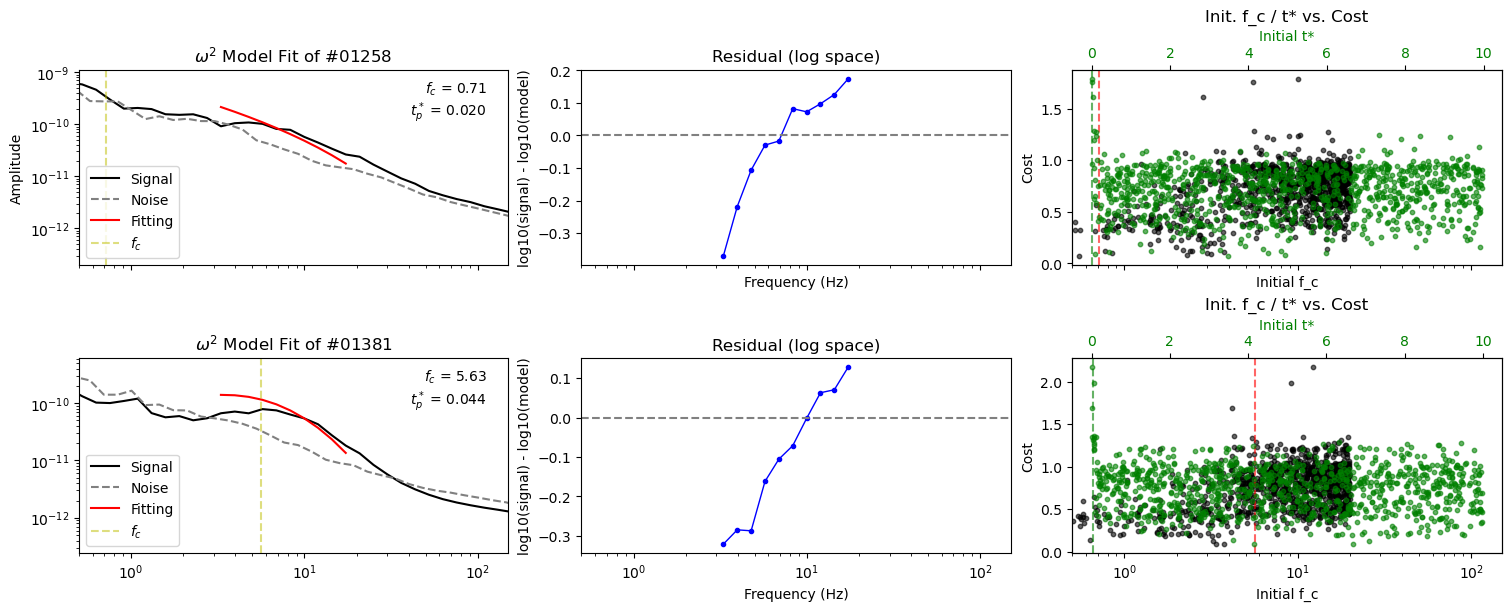

In [30]:
##### === Plot Spectra Fitting ===
omega_results_resample, fitting, f_filtered = plot_velocity_spectra_iteration(
    signal_freq_resampled,
    signal_amp_resampled,
    noise_freq_resampled,
    noise_amp_resampled,
    wv,
    initial_guess=[1e-10, 10, 0.01],
    f_range=(3, 20),
    wave=wave_type,
    save_path=save_path,
    save_name='omega_fit_resampled'
)

In [31]:
fc_avg = (omega_results_resample[0]['f_c']+omega_results_resample[1]['f_c'])/2
delta_f = signal_freq_list[0][1] - signal_freq_list[0][0]

斜率 a: -0.015 ± 0.038
截距 b: 0.330 ± 0.480
Δt_p*: 0.0047 ± 0.0239
***********************
[ORIGINAL] Assume v = 2442.81 m/s, ds = 500 m
Q = 43.95 (+54.61, -36.77)


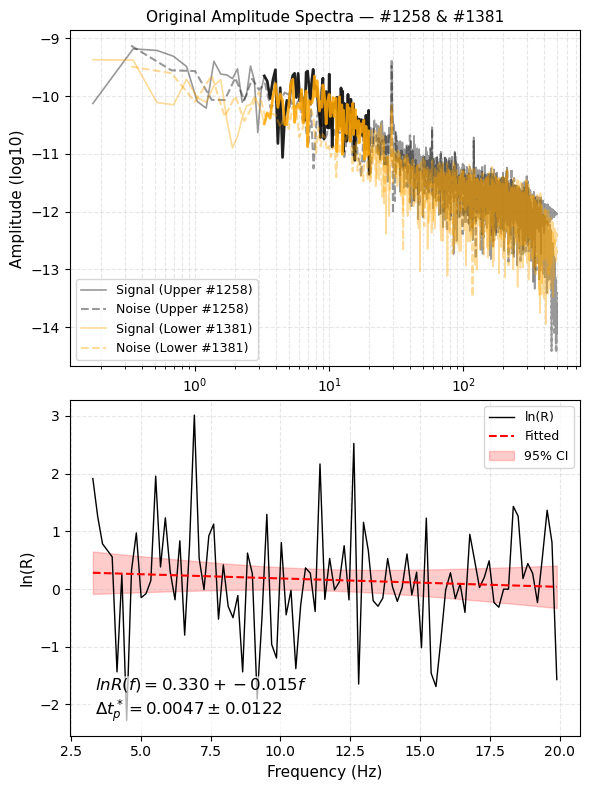

In [32]:
# === Amplitude Ratio (Original) ===
fit_range = (fc_avg, 20)
mask = (signal_freq_list[0] >= fit_range[0]) & (signal_freq_list[0] <= fit_range[1])
fit_freq = signal_freq_list[0][mask]
fit_amp_0 = signal_amp_list[0][mask]
fit_amp_1 = signal_amp_list[1][mask]
lnR_a = np.log(fit_amp_0 / fit_amp_1)
coeffs_a, cov_a = np.polyfit(fit_freq, lnR_a, 1, cov=True)
slope_a, intercept_a = coeffs_a
lnR_fit_a = np.polyval(coeffs_a, fit_freq)
lnR_std_a = np.sqrt((fit_freq**2)*cov_a[0,0] + cov_a[1,1] + 2*fit_freq*cov_a[0,1])
lnR_upper_a = lnR_fit_a + 1.96 * lnR_std_a
lnR_lower_a = lnR_fit_a - 1.96 * lnR_std_a
tps_ori = -slope_a / np.pi
ts_error_ori = 1.96 * (np.sqrt(cov_a[0,0]) / np.pi)

Q_value_ori = ds / (v * tps_ori)
Q_error_ori = abs((ds / (v * (tps_ori - ts_error_ori))) - Q_value_ori)
Q_error_neg_ori = abs((ds / (v * (tps_ori + ts_error_ori))) - Q_value_ori)

# --- Plot ---
fig, axs = plt.subplots(2, 1, figsize=(6, 8))

# --- 上圖：Signal, Noise, Fit of both stations ---
axs[0].plot(signal_freq_list[0], np.log10(signal_amp_list[0]), color='black', linewidth=1.2, alpha=0.4, label=f'Signal (Upper #{station1})')
axs[0].plot(noise_freq_list[0], np.log10(noise_amp_list[0]), color='black', linestyle='--', alpha=0.4, label=f'Noise (Upper #{station1})')
axs[0].plot(fit_freq, np.log10(fit_amp_0), color='black', linewidth=2.0, alpha=0.8)

axs[0].plot(signal_freq_list[1], np.log10(signal_amp_list[1]), color='orange', linewidth=1.2, alpha=0.4, label=f'Signal (Lower #{station2})')
axs[0].plot(noise_freq_list[1], np.log10(noise_amp_list[1]), color='orange', linestyle='--', alpha=0.4, label=f'Noise (Lower #{station2})')
axs[0].plot(fit_freq, np.log10(fit_amp_1), color='orange', linewidth=2.0, alpha=0.8)

axs[0].set_title(f"Original Amplitude Spectra — #{station1} & #{station2}", fontsize=11)
axs[0].set_ylabel("Amplitude (log10)", fontsize=11)
axs[0].set_xscale("log")
axs[0].legend(fontsize=9)
axs[0].grid(True, which="both", linestyle="--", alpha=0.3)

axs[1].plot(fit_freq, lnR_a, color='k', label='ln(R)', linewidth=1)
axs[1].plot(fit_freq, lnR_fit_a, 'r--', label='Fitted')
axs[1].fill_between(fit_freq, lnR_lower_a, lnR_upper_a, color='red', alpha=0.2, label='95% CI')

axs[1].set_xlabel("Frequency (Hz)", fontsize=11)
axs[1].set_ylabel("ln(R)", fontsize=11)
axs[1].legend(fontsize=9)
axs[1].grid(True, linestyle="--", alpha=0.3)

textstr = (
    f"$lnR(f) = {intercept_a:.3f} + {slope_a:.3f}f$\n"
    f"$\\Delta t_{{{wave_type}}}^* = {tps_ori:.4f} \\pm {ts_error_ori:.4f}$"
)
axs[1].text(
    0.05, 0.03,
    textstr,
    transform=axs[1].transAxes,
    fontsize=12,
    ha='left',
    va='bottom',
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="none", alpha=0.7)
)

coeffs, variance, ts_info = fit_and_plot_amplitude_ratio(
    signal_amp_list,
    signal_freq_list,
    delta_f,
    wave=wave_type,
    f_range=fit_range,
    save_path=save_path,
    save_name='original_ratio'
)

print("***********************")

ts_ori = ts_info['ts']
ts_error_ori = ts_info['ts_error']
Q_value_ori = ds / (v * ts_ori)
Q_error_ori = abs((ds / (v * (ts_ori - ts_error_ori))) - Q_value_ori)
Q_error_neg_ori = abs((ds / (v * (ts_ori + ts_error_ori))) - Q_value_ori)

print(f"[ORIGINAL] Assume v = {v:.2f} m/s, ds = {ds} m\n"
      f"Q = {Q_value_ori:.2f} (+{Q_error_ori:.2f}, -{Q_error_neg_ori:.2f})")

plt.tight_layout()
plt.subplots_adjust(hspace=0.1)
plt.savefig(f"{save_path}/original_full.png", dpi=300)
plt.show()

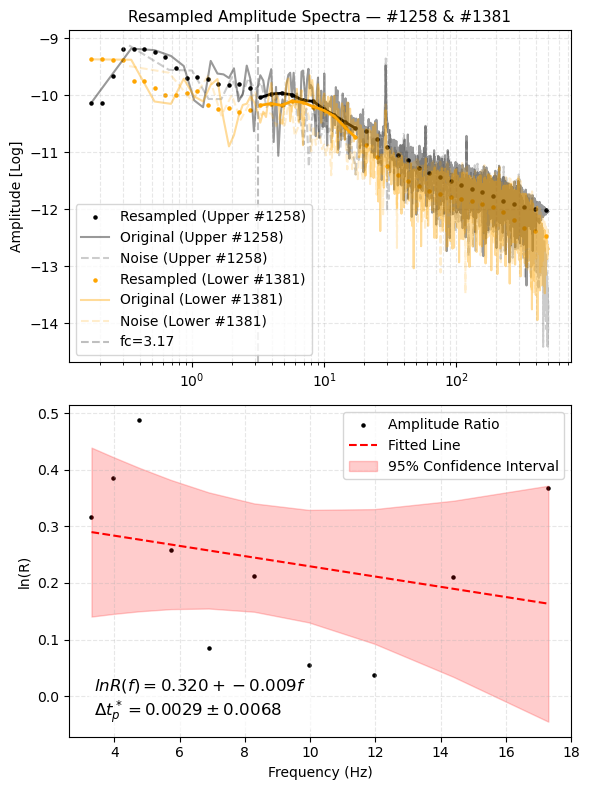

[RESAMPLED] Assume v = 2442.812140053892/s, Q value: 71.17 (+123.00, -50.07)


In [33]:
# === Amplitude Ratio (Resampled) ===
import statsmodels.api as sm

fit_range = (fc_avg, 20)
mask = (signal_freq_resampled >= fit_range[0]) & (signal_freq_resampled <= fit_range[1])
fit_freq = signal_freq_resampled[mask]
fit_amp_0 = signal_amp_resampled[0][mask]
fit_amp_1 = signal_amp_resampled[1][mask]

amp_ratio = 10**fit_amp_0 / 10**fit_amp_1
lnR = np.log(amp_ratio)

coefficients, covariance_matrix = np.polyfit(fit_freq, lnR, 1, cov=True)
slope, intercept = coefficients
slope_var, intercept_var = np.diag(covariance_matrix)
slope_std = np.sqrt(slope_var)
intercept_std = np.sqrt(intercept_var)
ci_slope = 1.96 * slope_std
ci_intercept = 1.96 * intercept_std

fitted_lnR = np.polyval(coefficients, fit_freq)
lnR_std = np.sqrt((fit_freq ** 2) * slope_var + intercept_var + 2 * fit_freq * covariance_matrix[0, 1])
fitted_upper = fitted_lnR + 1.96 * lnR_std
fitted_lower = fitted_lnR - 1.96 * lnR_std

tps = -slope / np.pi
tps_ci = 1.96 * (slope_std / np.pi)

fig, axs = plt.subplots(2, 1, figsize=(6, 8))
axs[0].scatter(signal_freq_resampled, signal_amp_resampled[0], color='k', s=5, label=f'Resampled (Upper #{station1})')
axs[0].plot(fit_freq, fit_amp_0, 'k', linewidth=2)
axs[0].plot(signal_freq_list[0], np.log10(signal_amp_list[0]), 'k', alpha=0.4, label=f'Original (Upper #{station1})')
axs[0].plot(noise_freq_list[0], np.log10(noise_amp_list[0]), 'k', linestyle='--', alpha=0.2, label=f'Noise (Upper #{station1})')
axs[0].scatter(signal_freq_resampled, signal_amp_resampled[1], color='orange', s=5, label=f'Resampled (Lower #{station2})')
axs[0].plot(fit_freq, fit_amp_1, 'orange', linewidth=2)
axs[0].plot(signal_freq_list[1], np.log10(signal_amp_list[1]), 'orange', alpha=0.4, label=f'Original (Lower #{station2})')
axs[0].plot(noise_freq_list[1], np.log10(noise_amp_list[1]), 'orange', linestyle='--', alpha=0.2, label=f'Noise (Lower #{station2})')
axs[0].axvline(fit_range[0], color='gray', linestyle='--', alpha=0.5, label=f'fc={fit_range[0]:.2f}')
axs[0].set_title(f"Resampled Amplitude Spectra — #{station1} & #{station2}", fontsize=11)
axs[0].set_ylabel("Amplitude [Log]")
axs[0].set_xscale("log")
axs[0].legend()
axs[0].grid(True, which="both", linestyle="--", alpha=0.3)

axs[1].scatter(fit_freq, lnR, s=5, color='k', label="Amplitude Ratio")
axs[1].plot(fit_freq, fitted_lnR, 'r--', label="Fitted Line")
axs[1].fill_between(fit_freq, fitted_lower, fitted_upper, color='red', alpha=0.2, label="95% Confidence Interval")
axs[1].set_xlabel("Frequency (Hz)")
axs[1].set_ylabel("ln(R)")
axs[1].legend()
axs[1].grid(True, linestyle="--", alpha=0.3)

textstr = (
    f"$lnR(f) = {intercept:.3f} + {slope:.3f}f$\n"
    f"$\\Delta t_{{{wave_type}}}^* = {tps:.4f} \\pm {tps_ci:.4f}$"
)
axs[1].text(0.05, 0.03, textstr, transform=plt.gca().transAxes, fontsize=12,
            verticalalignment='bottom', horizontalalignment='left', bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="none", alpha=0.7))

plt.tight_layout()
plt.savefig(f"{save_path}/resample_ratio.png", dpi=300)
plt.show()

ts_re = tps
ts_error_re = tps_ci

Q_value_re = ds / (v * ts_re)
Q_error_re = abs((ds / (v * (ts_re - ts_error_re))) - Q_value_re)
Q_error_neg_re = abs((ds / (v * (ts_re + ts_error_re))) - Q_value_re)

print(f"[RESAMPLED] Assume v = {v}/s, Q value: {Q_value_re:.2f} (+{Q_error_re:.2f}, -{Q_error_neg_re:.2f})")

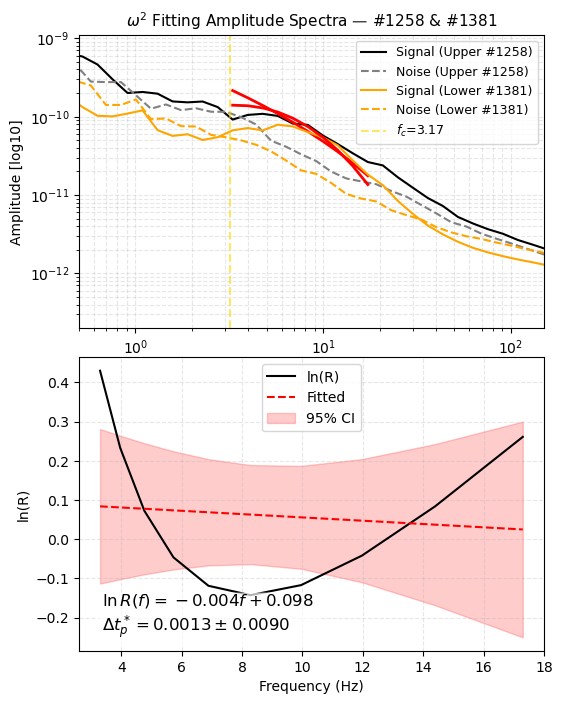

[OMEGA FITTING] Assume v = 2442.81 m/s, ds = 500.00 m
Q = 152.61 (+179.29, -132.85)


In [34]:
# === Amplitude Ratio (Omega-Square) ===
fig, axs = plt.subplots(2, 1, figsize=(6, 8))
plt.subplots_adjust(hspace=0.1)
fit_range = (fc_avg, 20)
mask = (f_filtered >= fit_range[0]) & (f_filtered <= fit_range[1])

for i, ax in enumerate([axs[0], axs[0]]):
    f = f_filtered[mask]
    amp_obs = signal_amp_resampled[i]
    amp_noise = noise_amp_resampled[i]

    # 擬合資料
    station_id = omega_results_resample[i]["station"]
    fc = omega_results_resample[i]["f_c"]
    tstar = omega_results_resample[i]["t_star"]

    # 顏色與標籤設定
    signal_color = 'k' if i == 0 else 'orange'
    noise_color = 'gray' if i == 0 else 'orange'
    label_suffix = f"(Upper #{station1})" if i == 0 else f"(Lower #{station2})"

    axs[0].plot(
        signal_freq_resampled,
        10**amp_obs,
        color=signal_color,
        label=f"Signal {label_suffix}"
    )
    axs[0].plot(
        noise_freq_resampled,
        10**amp_noise,
        color=noise_color,
        linestyle='--',
        label=f"Noise {label_suffix}"
    )
    axs[0].plot(f_filtered, 10**fitting[i], 'r', linewidth=2)

    # axs[0].text(
    #     0.95,
    #     0.95 - i * 0.2,
    #     rf"${{f_c}}$ = {fc:.3f}" + "\n" + rf"$t_{{{wave_type}}}^*$ = {tstar:.3f}",
    #     transform=axs[0].transAxes,
    #     fontsize=11,
    #     ha='right',
    #     va='top'
    # )

axs[0].axvline(fc_avg, color='gold', linestyle='--', alpha=0.6, label=rf'$f_c$={fc_avg:.2f}')
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_xlim(0.5, 150)
axs[0].set_ylabel("Amplitude [log10]")
axs[0].set_title(rf"$\omega^2$ Fitting Amplitude Spectra — #{station1} & #{station2}", fontsize=11)
axs[0].legend(fontsize=9)
axs[0].grid(True, which="both", linestyle='--', alpha=0.3)

lnR = np.log(10**fitting[0]/10**fitting[1])[mask]
coeffs, cov = np.polyfit(f, lnR, 1, cov=True)
slope, intercept = coeffs
lnR_fit = np.polyval(coeffs, f)
lnR_std = np.sqrt((f**2) * cov[0, 0] + cov[1, 1] + 2 * f * cov[0, 1])
lnR_upper = lnR_fit + 1.96 * lnR_std
lnR_lower = lnR_fit - 1.96 * lnR_std
tps = -slope / np.pi
tps_ci = 1.96 * (np.sqrt(cov[0, 0]) / np.pi)

axs[1].plot(f, lnR, 'k', label='ln(R)')
axs[1].plot(f, lnR_fit, 'r--', label='Fitted')
axs[1].fill_between(f, lnR_lower, lnR_upper, color='red', alpha=0.2, label='95% CI')
axs[1].set_xlabel("Frequency (Hz)")
axs[1].set_ylabel("ln(R)")
axs[1].legend()
axs[1].grid(True, linestyle='--', alpha=0.3)

textstr = (
    rf"$\ln R(f) = {slope:.3f}f + {intercept:.3f}$" + "\n" +
    rf"$\Delta t_{{{wave_type}}}^* = {tps:.4f} \pm {tps_ci:.4f}$"
)
axs[1].text(0.05, 0.03, textstr,
            transform=axs[1].transAxes,
            fontsize=12, ha='left', va='bottom',
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="none", alpha=0.7))

plt.savefig(f"{save_path}/omega_full_combined.png", dpi=300)
plt.show()

ts = tps                  # Δt_p* or Δt_s*
ts_error = tps_ci         # 95% CI

Q_value = ds / (v * ts)
Q_error = abs((ds / (v * (ts - ts_error))) - Q_value)  # 上界
Q_error_neg = abs((ds / (v * (ts + ts_error))) - Q_value)  # 下界

print(f"[OMEGA FITTING] Assume v = {v:.2f} m/s, ds = {ds:.2f} m")
print(f"Q = {Q_value:.2f} (+{Q_error:.2f}, -{Q_error_neg:.2f})")

In [35]:
Q_value, Q_value_re, Q_value_ori

(152.6148463745281, 71.16559115176129, 43.947662736618966)